# Variational Autoencoders

In this notebook, we will build a Variational Autoencoder (VAE) trained on the MNIST dataset and see how it can generate new images.

A Variational Autoencoder (VAE) is a type of generative model that learns to encode input data into a lower-dimensional latent space and then decodes this latent representation back into the original data space. Unlike traditional autoencoders, VAEs introduce a probabilistic twist: they learn the distribution of the latent space rather than just a fixed encoding.

### How VAEs Generate New Images:

1. **Encoder Network**: The encoder network maps input data (e.g., MNIST images) to a latent space by producing two vectors: the mean and the standard deviation of the latent variables' distribution. This allows the VAE to learn a probabilistic distribution of the input data.

2. **Reparameterization Trick**: To enable backpropagation through the network, a reparameterization trick is used. Instead of directly sampling from the distribution, the network samples from a standard normal distribution and shifts/scales it using the learned mean and standard deviation.

3. **Latent Space**: The latent space is a lower-dimensional representation where similar inputs are mapped close to each other. This space captures the underlying factors of variation in the data.

4. **Decoder Network**: The decoder network takes samples from the latent space and reconstructs them back into the original data space. During training, the decoder learns to generate data that resembles the original input.

5. **Loss Function**: The VAE is trained using a loss function that combines reconstruction loss (how well the decoded output matches the input) and a regularization term (KL divergence) that ensures the learned latent space follows a standard normal distribution.

By learning the distribution of the latent space, VAEs can generate new images by sampling from this space and passing the samples through the decoder network. This allows VAEs to produce novel data that resembles the original training data, making them powerful tools for generative tasks.

## Imports

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from IPython import display

## Parameters

In [ ]:
# Define global constants to be used in this notebook
BATCH_SIZE=128
LATENT_DIM=2

## Prepare the Dataset

We will be using the `train` split of the MNIST dataset in this notebook. Below are some helper functions to assist in downloading and preparing the dataset:

* `map_image()`: This function normalizes the images and creates a tensor from each image. It returns only the image since we are performing unsupervised learning with the autoencoder.

* `get_dataset()`: This function loads the MNIST dataset from Tensorflow Datasets, fetching the `train` split by default. It then prepares the data using the `map_image` function. If the `is_validation` parameter is set to `True`, it fetches the `test` split instead. Training sets are also shuffled for better training performance.

In [ ]:
def map_image(image, label):
  '''returns a normalized and reshaped tensor from a given image'''
  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0
  image = tf.reshape(image, shape=(28, 28, 1,))

  return image


def get_dataset(map_fn, is_validation=False):
  '''Loads and prepares the mnist dataset from TFDS.'''
  if is_validation:
    split_name = "test"
  else:
    split_name = "train"

  dataset = tfds.load('mnist', as_supervised=True, split=split_name)
  dataset = dataset.map(map_fn)

  if is_validation:
    dataset = dataset.batch(BATCH_SIZE)
  else:
    dataset = dataset.shuffle(1024).batch(BATCH_SIZE)

  return dataset

In [ ]:
train_dataset = get_dataset(map_image)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


## Build the Model

We will now build our VAE model, which consists of several key components as shown in the figure below:

<img src="https://drive.google.com/uc?export=view&id=1YAZAeMGEJ1KgieYk1ju-S9DoshpMREeC" width="60%" height="60%"/>

Similar to the autoencoder architecture used in the `AutoEncoders` notebooks, the VAE has an encoder-decoder architecture. However, the main difference is the inclusion of a latent representation layer, depicted by the grey box in the middle. In this layer, the model incorporates a random sample and combines it with the outputs of the encoder. This mechanism is what enables the VAE to generate new content. We will build these components step-by-step in the following sections.

### Sampling Class

First, we will build the `Sampling` class. This will be a custom Keras layer that provides the Gaussian noise input along with the mean (\(\mu\)) and standard deviation (\(\sigma\)) of the encoder's output. In practice, the output of this layer is given by the equation:

$$ z = \mu + e^{0.5\sigma} \cdot \epsilon \ $$

where $\mu$ is the mean, $\sigma$ is the standard deviation, and $\epsilon$ is a random sample.

In [ ]:
class Sampling(tf.keras.layers.Layer):
  def call(self, inputs):
    """Generates a random sample and combines with the encoder output

    Args:
      inputs -- output tensor from the encoder

    Returns:
      `inputs` tensors combined with a random sample
    """

    # Unpack the output of the encoder
    mu, sigma = inputs

    # Get the size and dimensions of the batch
    batch = tf.shape(mu)[0]
    dim = tf.shape(mu)[1]

    # Generate a random tensor
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))

    # Combine the inputs and noise
    return mu + tf.exp(0.5 * sigma) * epsilon

### Encoder

Next, we will build the encoder part of the network. We will follow the architecture shown in class, which looks like this. Note that aside from \(\mu\) and \(\sigma\), we will also output the shape of features before flattening it. This will be useful when reconstructing the image later in the decoder.

*Note:* It is also possible that there might be issues with using batch normalization with smaller batches, and sometimes the advice is given to avoid using batch normalization when training VAEs in particular.

<img src="https://drive.google.com/uc?export=view&id=1eoxFK_UVSHd3a_5EHcCU8F8QDZlPiXfW" width="60%" height="60%"/>

In [ ]:
def encoder_layers(inputs, latent_dim):
  """Defines the encoder's layers.
  Args:
    inputs -- batch from the dataset
    latent_dim -- dimensionality of the latent space

  Returns:
    mu -- learned mean
    sigma -- learned standard deviation
    batch_2.shape -- shape of the features before flattening
  """

  # Add the Conv2D layers followed by BatchNormalization
  x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding="same", activation='relu', name="encode_conv1")(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name="encode_conv2")(x)

  # Assign to a different variable to extract the shape later
  batch_2 = tf.keras.layers.BatchNormalization()(x)

  # Flatten the features and feed into the Dense network
  x = tf.keras.layers.Flatten(name="encode_flatten")(batch_2)

  # We arbitrarily used 20 units here but feel free to change and see what results we get
  x = tf.keras.layers.Dense(20, activation='relu', name="encode_dense")(x)
  x = tf.keras.layers.BatchNormalization()(x)

  # Add output Dense networks for mu and sigma, units equal to the declared latent_dim.
  mu = tf.keras.layers.Dense(latent_dim, name='latent_mu')(x)
  sigma = tf.keras.layers.Dense(latent_dim, name ='latent_sigma')(x)

  return mu, sigma, batch_2.shape

With the encoder layers defined, we can declare the encoder model that includes the `Sampling` layer.

In [ ]:
def encoder_model(latent_dim, input_shape):
  """Defines the encoder model with the Sampling layer
  Args:
    latent_dim -- dimensionality of the latent space
    input_shape -- shape of the dataset batch

  Returns:
    model -- the encoder model
    conv_shape -- shape of the features before flattening
  """

  # Declare the inputs tensor with the given shape
  inputs = tf.keras.layers.Input(shape=input_shape)

  # Get the output of the encoder_layers() function
  mu, sigma, conv_shape = encoder_layers(inputs, latent_dim=LATENT_DIM)

  # Feed mu and sigma to the Sampling layer
  z = Sampling()((mu, sigma))

  # Build the whole encoder model
  model = tf.keras.Model(inputs, outputs=[mu, sigma, z])

  return model, conv_shape

### Decoder

Next, we will build the decoder part of the network, which expands the latent representations back to the original image dimensions. We can feed random inputs to this model, and it will generate content that resembles the training data. This will be done later in the training loop.

In [ ]:
def decoder_layers(inputs, conv_shape):
  """Defines the decoder layers.
  Args:
    inputs -- output of the encoder
    conv_shape -- shape of the features before flattening

  Returns:
    tensor containing the decoded output
  """

  # Feed to a Dense network with units computed from the conv_shape dimensions
  units = conv_shape[1] * conv_shape[2] * conv_shape[3]
  x = tf.keras.layers.Dense(units, activation = 'relu', name="decode_dense1")(inputs)
  x = tf.keras.layers.BatchNormalization()(x)

  # Reshape output using the conv_shape dimensions
  x = tf.keras.layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]), name="decode_reshape")(x)

  # Upsample the features back to the original dimensions
  x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu', name="decode_conv2d_2")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu', name="decode_conv2d_3")(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same', activation='sigmoid', name="decode_final")(x)

  return x

We can now define the decoder model.

In [ ]:
def decoder_model(latent_dim, conv_shape):
  """Defines the decoder model.
  Args:
    latent_dim -- dimensionality of the latent space
    conv_shape -- shape of the features before flattening

  Returns:
    model -- the decoder model
  """

  # Set the inputs to the shape of the latent space
  inputs = tf.keras.layers.Input(shape=(latent_dim,))

  # Get the output of the decoder layers
  outputs = decoder_layers(inputs, conv_shape)

  # Declare the inputs and outputs of the model
  model = tf.keras.Model(inputs, outputs)

  return model

### Kullback–Leibler Divergence

To improve the generative capability of the model, we need to account for the random normal distribution introduced in the latent space. To achieve this, we compute the [Kullback–Leibler Divergence](https://arxiv.org/abs/2002.07514) and add it to the reconstruction loss. The formula is defined in the function below.

In [ ]:
def kl_reconstruction_loss(inputs, outputs, mu, sigma):
  """ Computes the Kullback-Leibler Divergence (KLD)
  Args:
    inputs -- batch from the dataset
    outputs -- output of the Sampling layer
    mu -- mean
    sigma -- standard deviation

  Returns:
    KLD loss
  """
  kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
  kl_loss = tf.reduce_mean(kl_loss) * -0.5

  return kl_loss

### VAE Model

We can now define the entire VAE model. Note the use of `model.add_loss()` to incorporate the KL divergence into the total loss. Since computing the KL divergence doesn't require `y_true` and `y_pred`, it cannot be included directly in `model.compile()`. Therefore, we add it as an additional loss to ensure it is considered during training.

In [ ]:
def vae_model(encoder, decoder, input_shape):
  """Defines the VAE model
  Args:
    encoder -- the encoder model
    decoder -- the decoder model
    input_shape -- shape of the dataset batch

  Returns:
    the complete VAE model
  """

  # Set the inputs
  inputs = tf.keras.layers.Input(shape=input_shape)

  # Get mu, sigma, and z from the encoder output
  mu, sigma, z = encoder(inputs)

  # Get reconstructed output from the decoder
  reconstructed = decoder(z)

  # Define the inputs and outputs of the VAE
  model = tf.keras.Model(inputs=inputs, outputs=reconstructed)

  # Add the KL loss
  loss = kl_reconstruction_loss(inputs, z, mu, sigma)
  model.add_loss(loss)

  return model

We will add a helper function to set up and retrieve the various models using the functions we've defined.

In [ ]:
def get_models(input_shape, latent_dim):
  """Returns the encoder, decoder, and vae models"""
  encoder, conv_shape = encoder_model(latent_dim=latent_dim, input_shape=input_shape)
  decoder = decoder_model(latent_dim=latent_dim, conv_shape=conv_shape)
  vae = vae_model(encoder, decoder, input_shape=input_shape)
  return encoder, decoder, vae

In [ ]:
# Get the encoder, decoder and 'master' model (called vae)
encoder, decoder, vae = get_models(input_shape=(28,28,1,), latent_dim=LATENT_DIM)

## Train the Model

We can now set up the VAE model for training by defining the reconstruction loss, optimizer, and metrics.

In [ ]:
# Define our loss functions and optimizers
optimizer = tf.keras.optimizers.Adam()
loss_metric = tf.keras.metrics.Mean()
bce_loss = tf.keras.losses.BinaryCrossentropy()

To monitor the progress of image generation at each epoch, we can use the helper function provided below. This function will generate 16 images arranged in a 4x4 grid.

In [ ]:
def generate_and_save_images(model, epoch, step, test_input):
  """Helper function to plot our 16 images

  Args:

  model -- the decoder model
  epoch -- current epoch number during training
  step -- current step number during training
  test_input -- random tensor with shape (16, LATENT_DIM)
  """

  # Generate images from the test input
  predictions = model.predict(test_input)

  # Plot the results
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  # Tight_layout minimizes the overlap between 2 sub-plots
  fig.suptitle("epoch: {}, step: {}".format(epoch, step))
  plt.savefig('image_at_epoch_{:04d}_step{:04d}.png'.format(epoch, step))
  plt.show()

The training loop will display generated images. Notice that the KLD loss is added to the binary crossentropy loss before obtaining the gradients and updating the weights.

Initially, the 16 generated images will appear random, but as the network trains, these images will progressively resemble the MNIST dataset.

1/1 [==============================] - 0s 24ms/step


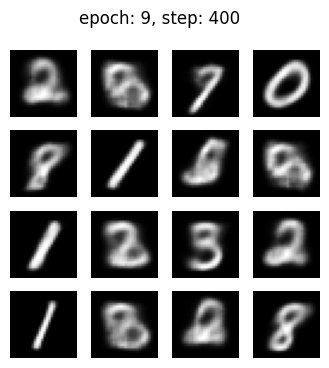

Epoch: 9 step: 400 mean loss = 155.8511


In [ ]:
# Training loop.

# Generate random vector as test input to the decoder
random_vector_for_generation = tf.random.normal(shape=[16, LATENT_DIM])

# Number of epochs
epochs = 10

# Initialize the helper function to display outputs from an untrained model
generate_and_save_images(decoder, 0, 0, random_vector_for_generation)

for epoch in range(epochs):
  print('Start of epoch %d' % (epoch,))

  # Iterate over the batches of the dataset.
  for step, x_batch_train in enumerate(train_dataset):
    with tf.GradientTape() as tape:

      # Feed a batch to the VAE model
      reconstructed = vae(x_batch_train)

      # Compute reconstruction loss
      flattened_inputs = tf.reshape(x_batch_train, shape=[-1])
      flattened_outputs = tf.reshape(reconstructed, shape=[-1])
      loss = bce_loss(flattened_inputs, flattened_outputs) * 784

      # Add KLD regularization loss
      loss += sum(vae.losses)

    # Get the gradients and update the weights
    grads = tape.gradient(loss, vae.trainable_weights)
    optimizer.apply_gradients(zip(grads, vae.trainable_weights))

    # Compute the loss metric
    loss_metric(loss)

    # Display outputs every 100 steps
    if step % 100 == 0:
      display.clear_output(wait=False)
      generate_and_save_images(decoder, epoch, step, random_vector_for_generation)
      print('Epoch: %s step: %s mean loss = %s' % (epoch, step, loss_metric.result().numpy()))